In [2]:
import pandas as pd

df_ml = pd.read_csv("results_ml/ml_predictions_full.csv")
df_ml["timestamp"] = pd.to_datetime(df_ml["timestamp"])

print(df_ml.shape)
print(df_ml.columns.tolist())

(4099, 105)
['timestamp', 'open', 'high', 'low', 'close', 'volume', 'fut_open', 'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_oi', 'ce_close', 'ce_oi', 'ce_vol', 'pe_close', 'pe_oi', 'pe_vol', 'ema_5', 'ema_15', 'spot_ret', 'fut_ret', 'futures_basis', 'pcr_oi', 'pcr_vol', 'atm_strike', 't_years', 'iv_call', 'iv_put', 'delta_call', 'gamma_call', 'theta_call', 'vega_call', 'rho_call', 'delta_put', 'gamma_put', 'theta_put', 'vega_put', 'rho_put', 'avg_iv', 'iv_spread', 'delta_neutral_ratio', 'gamma_exposure_call', 'gamma_exposure_put', 'spot_returns', 'state', 'regime', 'regime_fixed', 'ema_fast', 'ema_slow', 'cross_up', 'cross_dn', 'long_entry', 'short_entry', 'long_exit', 'short_exit', 'position', 'spot_return', 'position_next', 'strategy_return', 'equity', 'target', 'hour', 'minute', 'dayofweek', 'ema_diff', 'ema_diff_pct', 'spot_return_lag1', 'spot_return_lag2', 'spot_return_lag3', 'futures_basis_lag1', 'futures_basis_lag2', 'futures_basis_lag3', 'avg_iv_lag1', 'avg_iv_lag2',

In [3]:
import numpy as np
import pandas as pd

# Use LSTM filtered strategy (best one)
df_ml["pos_use"] = df_ml["position_lstm"]

trades = []
pos = 0
entry_i = None
entry_price = None

for i in range(len(df_ml)):
    p = df_ml["pos_use"].iloc[i]
    price = df_ml["close"].iloc[i]

    if pos == 0 and p != 0:
        pos = p
        entry_i = i
        entry_price = price

    elif pos != 0 and p == 0:
        exit_price = price
        pnl = (exit_price - entry_price) * pos
        duration = i - entry_i

        trades.append({
            "entry_time": df_ml["timestamp"].iloc[entry_i],
            "exit_time": df_ml["timestamp"].iloc[i],
            "direction": "LONG" if pos == 1 else "SHORT",
            "pnl": pnl,
            "duration_bars": duration
        })
        pos = 0

trades_df = pd.DataFrame(trades)

print("Total trades:", len(trades_df))
print(trades_df.head())

# Z-score outliers
trades_df["zscore"] = (trades_df["pnl"] - trades_df["pnl"].mean()) / trades_df["pnl"].std()
outliers = trades_df[trades_df["zscore"] > 3]

print("Outlier trades:", len(outliers))
print("Outlier %:", round(len(outliers)/len(trades_df)*100, 2), "%")
outliers.sort_values("zscore", ascending=False).head()

Total trades: 97
                 entry_time                 exit_time direction    pnl  \
0 2025-11-03 11:35:00+05:30 2025-11-03 11:40:00+05:30      LONG -10.10   
1 2025-11-03 13:35:00+05:30 2025-11-03 13:40:00+05:30      LONG   2.45   
2 2025-11-03 13:45:00+05:30 2025-11-03 13:50:00+05:30      LONG   5.30   
3 2025-11-03 13:55:00+05:30 2025-11-03 14:05:00+05:30      LONG  -9.10   
4 2025-11-03 14:15:00+05:30 2025-11-03 14:20:00+05:30      LONG  10.25   

   duration_bars  
0              1  
1              1  
2              1  
3              2  
4              1  
Outlier trades: 3
Outlier %: 3.09 %


,entry_time,exit_time,direction,pnl,duration_bars,zscore
12,2025-11-11 12:20:00+05:30,2025-11-12 09:25:00+05:30,LONG,236.90,40,4.755983
93,2026-01-14 15:05:00+05:30,2026-01-16 10:45:00+05:30,LONG,182.75,23,3.654035
84,2026-01-09 09:25:00+05:30,2026-01-09 13:40:00+05:30,SHORT,157.10,51,3.132060


In [4]:
# Remove outlier trades (zscore > 3)
clean_trades = trades_df[trades_df["zscore"] <= 3].copy()

print("Trades before:", len(trades_df))
print("Trades after :", len(clean_trades))

# Compare total pnl
print("Total PnL before:", trades_df["pnl"].sum())
print("Total PnL after :", clean_trades["pnl"].sum())

Trades before: 97
Trades after : 94
Total PnL before: 309.39999999998327
Total PnL after : -267.3500000000204


In [5]:
# Step 3: Rebuild equity curve from cleaned trades
df_eq = df_ml.copy()
df_eq["equity_clean"] = 1.0

# mark trade pnl at exit candle
df_eq["trade_pnl_clean"] = 0.0

for _, t in clean_trades.iterrows():
    exit_time = pd.to_datetime(t["exit_time"])
    pnl = t["pnl"]

    # add pnl at exit time row
    idx = df_eq.index[df_eq["timestamp"] == exit_time]
    if len(idx) > 0:
        df_eq.loc[idx[0], "trade_pnl_clean"] += pnl

# convert pnl to equity (simple additive scaling)
# (you can change divisor to your capital size)
capital = 100000  # assume 1 lakh capital
df_eq["equity_clean"] = (1 + df_eq["trade_pnl_clean"].cumsum() / capital)

print(df_eq[["timestamp", "trade_pnl_clean", "equity_clean"]].tail())

                     timestamp  trade_pnl_clean  equity_clean
4094 2026-01-16 15:05:00+05:30             0.00      0.997386
4095 2026-01-16 15:10:00+05:30             0.00      0.997386
4096 2026-01-16 15:15:00+05:30             0.00      0.997386
4097 2026-01-16 15:20:00+05:30            -5.95      0.997326
4098 2026-01-16 15:25:00+05:30             0.00      0.997326


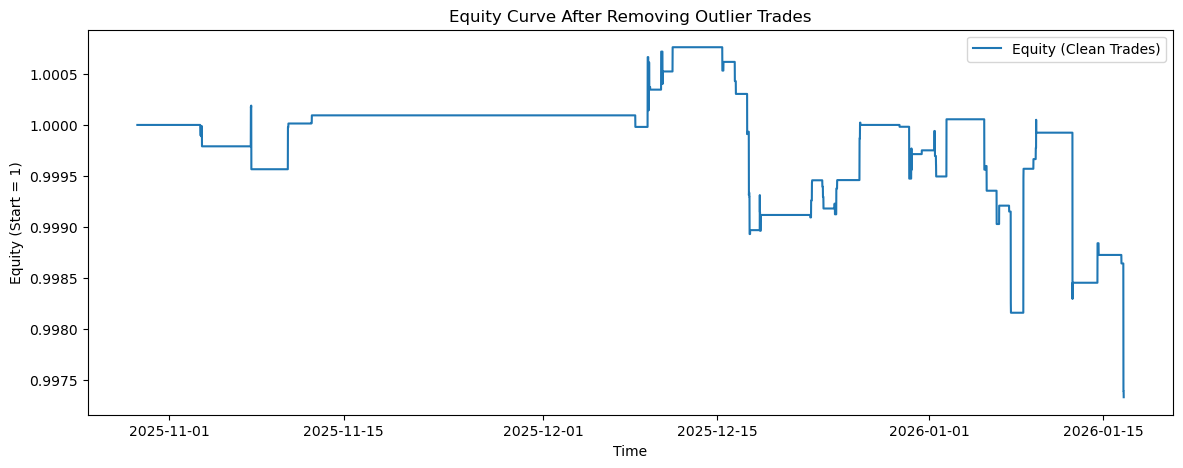

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(df_eq["timestamp"], df_eq["equity_clean"], label="Equity (Clean Trades)")
plt.title("Equity Curve After Removing Outlier Trades")
plt.xlabel("Time")
plt.ylabel("Equity (Start = 1)")
plt.legend()
plt.show()

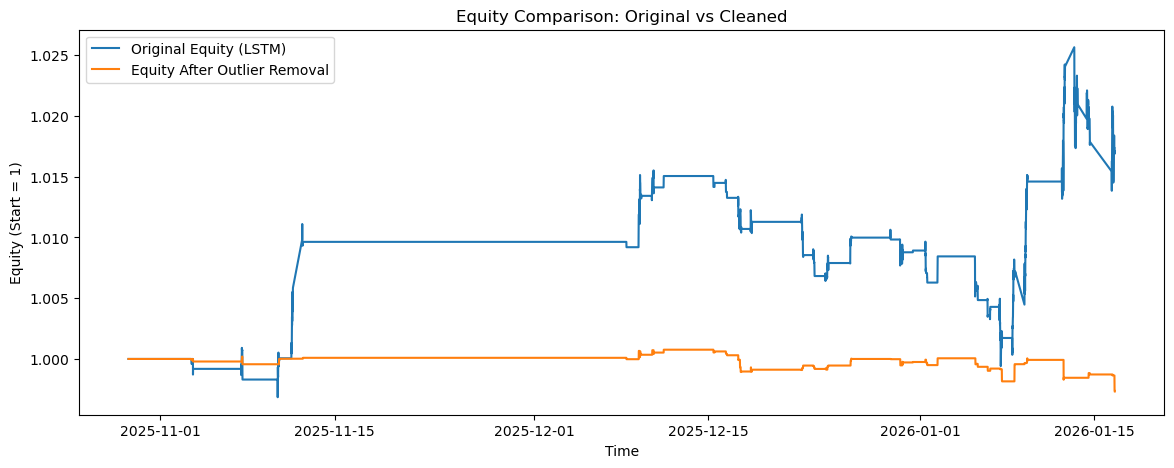

In [7]:
plt.figure(figsize=(14,5))

# baseline equity (if exists in df_ml)
if "equity_lstm" in df_ml.columns:
    plt.plot(df_ml["timestamp"], df_ml["equity_lstm"], label="Original Equity (LSTM)")
elif "equity" in df_ml.columns:
    plt.plot(df_ml["timestamp"], df_ml["equity"], label="Original Equity")

plt.plot(df_eq["timestamp"], df_eq["equity_clean"], label="Equity After Outlier Removal")

plt.title("Equity Comparison: Original vs Cleaned")
plt.xlabel("Time")
plt.ylabel("Equity (Start = 1)")
plt.legend()
plt.show()

In [8]:
final_equity_clean = df_eq["equity_clean"].iloc[-1]
total_return_clean = (final_equity_clean - 1) * 100

print("Final Equity (Clean):", final_equity_clean)
print("Total Return % (Clean):", total_return_clean)

Final Equity (Clean): 0.9973264999999998
Total Return % (Clean): -0.26735000000002174


In [9]:
# Use cleaned trades dataframe (trades_clean) created earlier
print("Total Trades (Clean):", len(trades_clean))
print("Total PnL (Clean):", trades_clean["pnl"].sum())

win_rate_clean = (trades_clean["pnl"] > 0).mean() * 100
print("Win Rate % (Clean):", win_rate_clean)

profit_factor_clean = trades_clean.loc[trades_clean["pnl"] > 0, "pnl"].sum() / abs(trades_clean.loc[trades_clean["pnl"] < 0, "pnl"].sum())
print("Profit Factor (Clean):", profit_factor_clean)

NameError: name 'trades_clean' is not defined

In [10]:
# trades_df already exists (your full trades list)
# outliers already exists (your outlier trades)

trades_clean = trades_df[~trades_df.index.isin(outliers.index)].copy().reset_index(drop=True)

print("Trades before:", len(trades_df))
print("Trades after :", len(trades_clean))
print("Total PnL before:", trades_df["pnl"].sum())
print("Total PnL after :", trades_clean["pnl"].sum())

Trades before: 97
Trades after : 94
Total PnL before: 309.39999999998327
Total PnL after : -267.3500000000204


In [11]:
print("Total Trades (Clean):", len(trades_clean))
print("Total PnL (Clean):", trades_clean["pnl"].sum())

win_rate_clean = (trades_clean["pnl"] > 0).mean() * 100
print("Win Rate % (Clean):", win_rate_clean)

profit_factor_clean = trades_clean.loc[trades_clean["pnl"] > 0, "pnl"].sum() / abs(trades_clean.loc[trades_clean["pnl"] < 0, "pnl"].sum())
print("Profit Factor (Clean):", profit_factor_clean)

Total Trades (Clean): 94
Total PnL (Clean): -267.3500000000204
Win Rate % (Clean): 51.06382978723404
Profit Factor (Clean): 0.7688183665527979


In [12]:
import numpy as np
import pandas as pd

# Build equity curve from cleaned trade pnl series (equity_clean_df already made earlier)
eq = equity_clean_df["equity_clean"].values
rets = pd.Series(eq).pct_change().fillna(0)

# Max Drawdown
running_max = np.maximum.accumulate(eq)
drawdown = (eq / running_max) - 1
max_dd = drawdown.min() * 100

# Total Return
total_return = (eq[-1] - 1) * 100

# Sharpe (5-min bars approx annualization)
bars_per_year = 252 * 75  # ~75 candles/day
sharpe = (rets.mean() / (rets.std() + 1e-9)) * np.sqrt(bars_per_year)

# Sortino
downside = rets[rets < 0]
sortino = (rets.mean() / (downside.std() + 1e-9)) * np.sqrt(bars_per_year)

# Calmar (annual return / max drawdown)
annual_return = (1 + rets.mean()) ** bars_per_year - 1
calmar = (annual_return / abs(drawdown.min() + 1e-9))

print("=== CLEANED PERFORMANCE ===")
print("Total Return %:", round(total_return, 3))
print("Sharpe:", round(sharpe, 3))
print("Sortino:", round(sortino, 3))
print("Calmar:", round(calmar, 3))
print("Max Drawdown %:", round(max_dd, 3))
print("Win Rate %:", round(win_rate_clean, 2))
print("Profit Factor:", round(profit_factor_clean, 3))
print("Total Trades:", len(trades_clean))

NameError: name 'equity_clean_df' is not defined

In [13]:
import pandas as pd
import numpy as np

# df_ml must already exist (from ML notebook)
# trades_clean must already exist (clean trades after removing outliers)

# Create empty pnl series on full timeline
equity_clean_df = df_ml[["timestamp"]].copy()
equity_clean_df["trade_pnl_clean"] = 0.0

# Put cleaned trade pnl on exit time
for _, row in trades_clean.iterrows():
    exit_time = row["exit_time"]
    pnl = row["pnl"]
    equity_clean_df.loc[equity_clean_df["timestamp"] == exit_time, "trade_pnl_clean"] += pnl

# Build equity curve
equity_clean_df["equity_clean"] = (1 + equity_clean_df["trade_pnl_clean"] / 100000).cumprod()

print(equity_clean_df[["timestamp","trade_pnl_clean","equity_clean"]].tail())

                     timestamp  trade_pnl_clean  equity_clean
4094 2026-01-16 15:05:00+05:30             0.00      0.997383
4095 2026-01-16 15:10:00+05:30             0.00      0.997383
4096 2026-01-16 15:15:00+05:30             0.00      0.997383
4097 2026-01-16 15:20:00+05:30            -5.95      0.997324
4098 2026-01-16 15:25:00+05:30             0.00      0.997324


In [14]:
import numpy as np
import pandas as pd

eq = equity_clean_df["equity_clean"].values
rets = pd.Series(eq).pct_change().fillna(0)

# Max Drawdown
peak = np.maximum.accumulate(eq)
drawdown = (eq - peak) / peak
max_dd = drawdown.min() * 100

# Sharpe / Sortino (5-min bars → annualized approx)
bars_per_year = 252 * 75
sharpe = (rets.mean() / (rets.std() + 1e-9)) * np.sqrt(bars_per_year)

downside = rets[rets < 0]
sortino = (rets.mean() / (downside.std() + 1e-9)) * np.sqrt(bars_per_year)

# Total return %
total_return = (eq[-1] - 1) * 100

print("CLEANED Total Return %:", total_return)
print("CLEANED Sharpe:", sharpe)
print("CLEANED Sortino:", sortino)
print("CLEANED Max Drawdown %:", max_dd)

CLEANED Total Return %: -0.26758453831243756
CLEANED Sharpe: -1.6668311573532515
CLEANED Sortino: -0.276212562934557
CLEANED Max Drawdown %: -0.34354484244459016


In [15]:
print("CLEANED Max Drawdown %:", abs(max_dd))

CLEANED Max Drawdown %: 0.34354484244459016


In [16]:
import os

os.makedirs("results_clean", exist_ok=True)

# 1) Save cleaned trades
trades_clean.to_csv("results_clean/trades_clean.csv", index=False)
print("Saved: results_clean/trades_clean.csv")

# 2) Save cleaned equity curve timeline
equity_clean_df.to_csv("results_clean/equity_clean_curve.csv", index=False)
print("Saved: results_clean/equity_clean_curve.csv")

Saved: results_clean/trades_clean.csv
Saved: results_clean/equity_clean_curve.csv
